## **Deterministic vs stochastic inverse problems**

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/adelval1/teaching/blob/master/Deterministic_vs_stochastic.ipynb)

In this notebook we explore the concepts of inverse problems as they are usually known for deterministic systems, and statistical inverse problems. The visualization exercise proposed consists of having a true model which is a polynomial and generating some noisy observations from which to calibrate our proposed model. We can then compare deterministic and stochastic techniques in light of the true model and its reconstruction resulting from both problems.

The observations are first used to fit a polynomial of arbitrary degree (hypothesis we present to fit the observations) without any account of uncertainties.

In [ ]:
import matplotlib.pyplot as plt 
import numpy as np 
from numpy import random
import scipy
from scipy.optimize import minimize
import pymc3 as pm
import theano
import theano.tensor as tt
import seaborn as sns

Next, we define the polynomial model which can take as inputs any set of coefficients $a_{k}$ defining any polynomial of arbitrary degree $q$: $y = \sum_{q=0}^{k} a_{k} x^{k}$. The functional to be minimized for the deterministic inverse problem is also defined. This functional is just the Root Mean Squared Error (RMSE) $\sqrt{\dfrac{1}{N}\sum_{i=1}^{N}\left(d_{i}-y_{i}\right)^{2}}$, where $N$ is the number of data points, $d_{i}$ is the $i$th data point and $y_{i}$ is the model prediction for $x_{i}$, which is the $x$ coordinate of the $i$th data point.

In [ ]:
def polynomial(a,x): # a is a vector with the polynomial coefficients in increasing order of polynomial degree
    a_tot = 0.
    for i in range(len(a)):
      a_tot += a[i]*np.power(x,i)
    return a_tot

def functional(q,x,u):
    L=0.
    for i in range(len(u)):
        L += np.power(u[i]-polynomial(q,x[i]),2)
    L = np.sqrt(np.divide(1,len(u))*L)
    return L

We define now the parameters for our fitting procedure. We generate the noisy observations with varying levels of noise and we split the data into segments to see the evolution of our fittings.

In [ ]:
# Random seed for the observations
# np.random.seed(2) # Uncomment if you want to compare different fittings when choosing different noise levels, observations or priors.
number_obs = 30 # Number of noisy observations generated
number_xs = 1000 # Number of x coordinate points to plot solutions once the fitting is done

# Mesh on x
x = np.linspace(0,1,number_xs)
spacing = int(number_xs/number_obs) # Spacing used to generate the observations at those x locations

# Generating the observations
x_obs = [x[spacing*i] for i in range(number_obs)] # spacing points on x
a_true = [10., -2., 7.5, -3.3, -3.2] # The true polynomial coefficients
sigma_obs = 0.1
observations = [polynomial(a_true,x[spacing*i])+np.random.normal(0,sigma_obs) for i in range(number_obs)] # The noisy observations

# We split the observations to see how the solution to the inverse problems evolve
obs_segments = 3

This next code snippet is the fitting of a polynomial of arbitrary degree to the noisy observations generated. Here we use the Nelder-Mead algorithm, which is a simplex method, to find the minimum of the RMSE functional proposed. The resulting polynomial coefficients are printed out.

In [ ]:
number_coeffs = 5 # Number of coefficients of the proposed polynomial to be fitted (hypothesis)
res = []
for i in range(obs_segments): # Fitting of the observation segments up to the last one
  if i==obs_segments-1:
    q = [1. for i in range(number_coeffs)]
    u = observations[0:number_obs-1]
    r = scipy.optimize.minimize(functional,q,args=(x_obs[0:number_obs-1],u),method='Nelder-Mead',tol=1e-6)
    res.append(r.x)

  else:
    q = [1. for i in range(number_coeffs)] # Fitting of the last observation segment of noisy observations, the length of this one is different, that's why it is taken out of the general loop
    u = observations[0:(i+1)*int(number_obs/(obs_segments+1))]
    r = scipy.optimize.minimize(functional,q,args=(x_obs[0:(i+1)*int(number_obs/(obs_segments+1))],u),method='Nelder-Mead',tol=1e-6)
    res.append(r.x)

#Printing of the computed polynomial coefficients
for i in range(obs_segments):
  print(res[i])

[ 10.00198424  -1.27262883  -5.41397895   5.78752532 120.15921583]
[ 10.0159031   -2.4217842    3.63146354  22.49038268 -36.5995843 ]
[ 10.02581988  -3.30703745  13.88953941 -13.68190371   2.20666982]


We plot the noisy observations of each segment along with the different fittings produced when increasingly taking into account more observations.

Text(0, 0.5, 'Y')

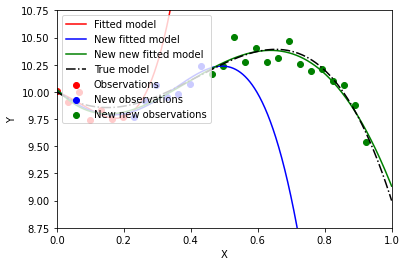

In [ ]:
colors=['red','blue','green']
labels=['Observations','New observations']

for i in range(obs_segments-1):
  plt.scatter(x_obs[i*int(number_obs/(obs_segments+1)):(i+1)*int(number_obs/(obs_segments+1))],observations[i*int(number_obs/(obs_segments+1)):(i+1)*int(number_obs/(obs_segments+1))],color=colors[i],label=labels[i])

plt.scatter(x_obs[2*int(number_obs/(obs_segments+1)):number_obs-1],observations[2*int(number_obs/(obs_segments+1)):number_obs-1],color='green',label='New new observations')
plt.plot(x,polynomial(res[0], x),color='red',label='Fitted model')
plt.plot(x,polynomial(res[1], x),color='blue',label='New fitted model')
plt.plot(x,polynomial(res[2], x),color='green',label='New new fitted model')
plt.plot(x,polynomial(a_true, x),color='black',linestyle = 'dashdot', label='True model')

plt.legend(loc='upper left')
plt.ylim(8.75,10.75)
plt.xlim(0.,1.)
plt.xlabel('X')
plt.ylabel('Y')

Several things can be noticed in this example. The most obvious is that as we increase the number of observations we take into account in our fitting exercise, we get better approximations to the true polynomial model.

Given the noisy nature of the observations (this is unavoidable even though we are used to see experimental data with no error bars), the fitted model is bound to change every time a new data point comes in. Further, the predictive properties of the fitted model are almost completely lost for the points ($x$ coordinates) where no data is found. This leaves us with a model with very bad predictive qualities. Moreover, as we don't account for any uncertainties in this exercise, we have no clue as to what extend we can trust the model we just fitted.

Lastly, the model we proposed (hypothesis made about the problem) does not correspond to the true model, nevertheless, we propose a general enough model that we are able to reasonably fit the data. This could have been a very different scenario with completely different hypotheses (models proposed). Try different models (linear, second order, exponential, logarithmic, periodic, etc) and check the results for when the inadequacy of the model becomes quite important.

In the next part of this exercise, we solve a statistical inverse problem. Now the noise of the observations is taken into account. The problem now is not to minimize the RMSE but to find the distribution of a group of model parameters (the polynomial coefficients $a_{k}$) that solves $\boldsymbol d - \boldsymbol y \ (\boldsymbol Q, x) = \boldsymbol E$, where $\boldsymbol d$ is the vector of the observations, $\boldsymbol y$ is the vector of the corresponding model outputs at the observation locations $x$, depending on the distribution associated to the polynomial coefficients $\boldsymbol Q$, and $\boldsymbol E$ is the observation noise distributions.

The solution of the statistical inverse problem is the distribution $\boldsymbol Q$ that solves such equation when the error model $\boldsymbol E$ is given in the form of probability distribution function. To solve this problem, we use the Bayesian formalism as already seen in the lecture. This next part of the exercise can take long so just let it run.

Sequential sampling (1 chains in 1 job)
NUTS: [a_4, a_3, a_2, a_1, a_0]
100%|██████████| 11000/11000 [00:38<00:00, 283.53it/s]
The acceptance probability does not match the target. It is 0.8871888794663603, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
NUTS: [a_4, a_3, a_2, a_1, a_0]
100%|██████████| 11000/11000 [01:19<00:00, 137.60it/s]
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5993409221880084, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
NUTS: [a_4, a_3, a_2, a_1, a_0]
100%|██████████| 11000/11000 [04:29<00:00, 40.85it/s]
The acceptance probability does not match the target. It is 0.89

Text(0, 0.5, 'Y')

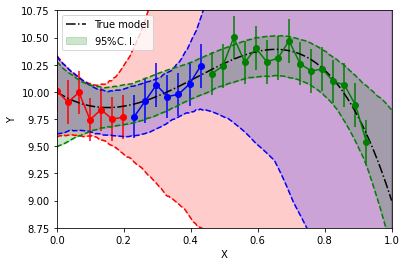

In [ ]:
#### Statistical inference ###

names_coeffs = ['a_'+str(i) for i in range(number_coeffs)]
sigma = 0.1

for i in range(obs_segments): 
  if i==obs_segments-1: # The same issue as earlier, we perform inferences for different observation segments and the last one is of slightly different length
    # set up your model
    with pm.Model():

        vect_var = [] # Vector of parameters for which we specify priors
        for j in range(number_coeffs):
          var_coeffs = pm.Uniform(names_coeffs[j], lower=-5., upper=20.) # Uniform priors with prescribed bounds. Look in the documentation of pyMC3 to find other prior models
          vect_var.append(var_coeffs)

        # convert coefficients to a tensor vector with theano (required by pyMC3 to work)
        theta = tt.as_tensor_variable(vect_var)

        # use a normal multivariate distribution as likelihood (noise taken as independet Gausssian distributions)
        mu = [polynomial(vect_var,x_obs[k]) for k in range(number_obs-1)] # Vector of mean values which are composed of the evaluations of the proposed model
        cov = sigma*np.identity(number_obs-1) # Covariance (noise of the observations)
        pm.MvNormal('likelihood', mu=mu, cov=cov, observed=observations[0:number_obs-1])

        step = pm.NUTS() # NUTS MCMC sampler. You can also try Metropolis or any other in the pyMC3 library!
        trace = pm.sample(10000, tune=1000, discard_tuned_samples=True, step=step, chains=1) # We get 10000 chain samples and discard the first 1000 that serve to tune the chain parameters

    ## Posterior statistics ##
    y_ci_plus = []
    y_ci_minus = []
    for l in range(len(x)):
        y_posterior = []
        for p in range(1000):
            coeffs = [trace[names_coeffs[m]][p] for m in range(number_coeffs)]
            y_posterior.append(polynomial(coeffs,x[l]))
        y_ci_plus.append(np.percentile(y_posterior,2.5))
        y_ci_minus.append(np.percentile(y_posterior,97.5))

    plt.plot(x,y_ci_plus,linestyle='--',color=colors[i])
    plt.plot(x,y_ci_minus,linestyle='--',color=colors[i])
    plt.fill_between(x,y_ci_plus,y_ci_minus,color=colors[i],alpha=0.2, label='$\mathrm{95\% C.I.}$')
    plt.errorbar(x_obs[(i)*int(number_obs/(obs_segments+1)):number_obs-1],observations[(i)*int(number_obs/(obs_segments+1)):number_obs-1],2*sigma,marker='o',color=colors[i])

  else:

    with pm.Model():
        
        vect_var = []
        for j in range(number_coeffs):
          var_coeffs = pm.Uniform(names_coeffs[j], lower=-5., upper=20.)
          vect_var.append(var_coeffs)

        theta = tt.as_tensor_variable(vect_var)

        mu = [polynomial(vect_var,x_obs[k]) for k in range((i+1)*int(number_obs/(obs_segments+1)))]
        cov = sigma*np.identity((i+1)*int(number_obs/(obs_segments+1)))
        pm.MvNormal('likelihood', mu=mu, cov=cov, observed=observations[0:(i+1)*int(number_obs/(obs_segments+1))])

        step = pm.NUTS()
        trace = pm.sample(10000, tune=1000, discard_tuned_samples=True, step=step, chains=1)

    ## Posterior statistics ##
    y_ci_plus = []
    y_ci_minus = []
    for l in range(len(x)):
        y_posterior = []
        for p in range(1000):
            coeffs = [trace[names_coeffs[m]][p] for m in range(number_coeffs)]
            y_posterior.append(polynomial(coeffs,x[l]))
        y_ci_plus.append(np.percentile(y_posterior,2.5))
        y_ci_minus.append(np.percentile(y_posterior,97.5))

    plt.plot(x,y_ci_plus,linestyle='--',color=colors[i])
    plt.plot(x,y_ci_minus,linestyle='--',color=colors[i])
    plt.fill_between(x,y_ci_plus,y_ci_minus,color=colors[i],alpha=0.2)
    plt.errorbar(x_obs[(i)*int(number_obs/(obs_segments+1)):(i+1)*int(number_obs/(obs_segments+1))],observations[(i)*int(number_obs/(obs_segments+1)):(i+1)*int(number_obs/(obs_segments+1))],2*sigma,marker='o',color=colors[i])

plt.plot(x,polynomial(a_true, x),color='black',linestyle = 'dashdot', label='True model')
plt.legend(loc='upper left')
plt.ylim(8.75,10.75)
plt.xlim(0.,1.)
plt.xlabel('X')
plt.ylabel('Y')


In this case, we can clearly see how the learning process unfolds. Unlike for the deterministic case, where there's only the "best" solution at a time which evolves as more data come in, Bayesian approaches refine the certainty about our predictions as more data become available. In this case, the red posterior envelops the true polynomial always, even though the uncertainty on the unseen data is quite large, still does a better job than the deterministic counterpart when it comes to robust predictions and predictive powers. As we increase the number of data points, our projected confidence (posterior predictive) in unseen data also increases. Lastly, when all points are used for the calibration, we get pretty accurate confidence intervals over the whole input domain.

Sometimes, the observations can be the end product of a complicated measurement process. It is only fair to question the uncertainty levels given by the experimentalists. To this end, we can propose to jointly infer the noise of the observations reported to us. The following polynomial function is tailored to work with the fact that the vector of parameters to be inferred and the vector of polynomial coefficients are different. In the former case, the input vector $a$ contains the standard deviation of the noise $\sigma$ and so the function is modified properly to account for this discrepancy with respect to the previous inference exercises.

In [ ]:
def polynomial_sigma(a,x): # a is a vector with the polynomial coefficients and the std dev of the observations
    a_tot = 0.
    for i in range(len(a)-1):
      a_tot += a[i]*np.power(x,i)
    return a_tot

The following snippet performs an inference including the noise of the observations $\sigma$. The prior selected for $\sigma$ is a logUniform distribution following Jeffrey's recommendations with $\mathcal{P}(\sigma^{2}) = \dfrac{1}{\sigma^{2}}$ for $\sigma^{2}>0$.

Sequential sampling (1 chains in 1 job)
NUTS: [sigma, a_4, a_3, a_2, a_1, a_0]
100%|██████████| 11000/11000 [10:24<00:00, 17.61it/s] 
There were 1760 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5810032326268394, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


Text(0, 0.5, 'Y')

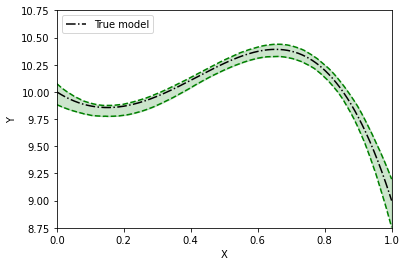

In [ ]:
names_coeffs = ['a_'+str(i) for i in range(number_coeffs)]
with pm.Model():
        
        vect_var = []
        for j in range(number_coeffs):
          var_coeffs = pm.Uniform(names_coeffs[j], lower=-5., upper=20.)
          vect_var.append(var_coeffs)
        sigma = pm.HalfFlat('sigma')
        # logsigma = pm.Uniform('sigma',lower=-4,upper=1.)
        vect_var.append(sigma)

        theta = tt.as_tensor_variable(vect_var)

        mu = [polynomial_sigma(vect_var,x_obs[k]) for k in range(number_obs-1)]
        # cov = np.power(10,vect_var[-1])*np.identity(number_obs-1)
        cov = vect_var[-1]*np.identity(number_obs-1)
        pm.MvNormal('likelihood', mu=mu, cov=cov, observed=observations[0:number_obs-1])
        prior = pm.Potential('prior', -tt.log(sigma))

        step = pm.NUTS()
        trace = pm.sample(10000, tune=1000, discard_tuned_samples=True, step=step, chains=1)

## Posterior statistics ##
y_ci_plus = []
y_ci_minus = []
for l in range(len(x)):
    y_posterior = []
    for p in range(1000):
        coeffs = [trace[names_coeffs[m]][p] for m in range(number_coeffs)]
        y_posterior.append(polynomial(coeffs,x[l]))
    y_ci_plus.append(np.percentile(y_posterior,2.5))
    y_ci_minus.append(np.percentile(y_posterior,97.5))
plt.plot(x,y_ci_plus,linestyle='--',color='green')
plt.plot(x,y_ci_minus,linestyle='--',color='green')
plt.fill_between(x,y_ci_plus,y_ci_minus,color='green',alpha=0.2)
# plt.errorbar(x_obs[(i)*int(number_obs/(obs_segments+1)):(i+1)*int(number_obs/(obs_segments+1))],observations[(i)*int(number_obs/(obs_segments+1)):(i+1)*int(number_obs/(obs_segments+1))],2*sigma,marker='o',color=colors[i])

plt.plot(x,polynomial(a_true, x),color='black',linestyle = 'dashdot', label='True model')
plt.legend(loc='upper left')
plt.ylim(8.75,10.75)
plt.xlim(0.,1.)
plt.xlabel('X')
plt.ylabel('Y')

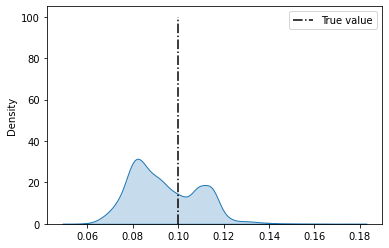

In [ ]:
sns.kdeplot(np.sqrt(trace['sigma']),shade=True)
plt.vlines(0.1,0.,100.,linestyle='dashdot',label='True value')
plt.legend(loc='best')